In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
planck = '/home/rt2122/Desktop/data-segmentation/data_src/Planck_SZ2.fits'
p_z = None
p_m = None
with fits.open(planck) as table:
    table.verify('fix')
    data = table[1].data
    keys = data.names
    print(keys)
    redshifts = np.array(data['z'])
    redshifts = redshifts[redshifts != -1]
    p_z = redshifts
    p_m = data['MSZ']
    p_m = p_m[p_m != 0]

 [astropy.io.fits.verify]


['Index', 'Name', 'GLON', 'GLAT', 'RAdeg', 'DEdeg', 'e_pos', 'SNR', 'Pipeline', 'PipeDet', 'PCCS2', 'PSZ', 'f_IR', 'q_neural', 'Y5R500', 'e_Y5R500', 'Val', 'zID', 'z', 'MSZ', 'E_MSZ', 'e_MSZ', 'MCXC', 'RedMAPPer', 'ACT', 'SPT', 'f_WISE', 'AMIevi', 'COSMO', 'Comment']


In [3]:
mcxc = '/home/rt2122/Desktop/data-segmentation/data_src/MCXC.fits'
m_z = None
m_m = None
with fits.open(mcxc) as mcxc_table:
    mcxc_table.verify('fix')
    m_data = mcxc_table[1].data
    m_keys = m_data.names
    key_names = m_keys[:3]

    mcxc_names = [m_data[x] for x in key_names]
    mcxc_names = np.array(mcxc_names).astype(str)

    mradec = [m_data['radeg'], m_data['dedeg']]
    mradec = np.array(mradec).astype(float)
    redshifts = m_data['z']
    redshifts = redshifts[redshifts != -1]
    m_z = redshifts
    m_m = m_data['M500']
    m_m = m_m[m_m != 0]

In [17]:
def calc_m500_redmapper(l_m_relation, z):
    from scipy.constants import h
    A = 66.1
    B = 1.14
    C = 0.73
    D = 0.15
    omega_m = 0.3
    omega_l = 0.7
    omega_k = 0
    e_z = np.sqrt(omega_m * (1 + z) ** 3 + omega_l + omega_k * (1 + z) ** 2)
    e_0_6 = np.sqrt(omega_m * (1 + 0.6) ** 3 + omega_l + omega_k * (1 + 0.6) ** 2)
    
    m_sun = 1.988 * (10 ** 30)
    cnt =  3 * (10 ** 14) * (h ** -1) * m_sun
   
    ans = np.exp(l_m_relation) * (cnt ** B) * (e_0_6 / e_z) ** C / A
    print(np.log(ans).min(), np.log(ans).max(), np.log(B))
    return np.log(ans) / np.log(B)

In [18]:
filename = '/home/rt2122/Desktop/data-segmentation/data_src/redmapper_dr8_public_v6.3_catalog.fits'
import pandas as pd
r_z = None
r_m = None
with fits.open(filename) as table:
    table.verify('fix')
    data = table[1].data
    data = data[data['LAMBDA'] > 50]
    data = data[data['Z_SPEC'] != -1]
    keys = data.names
    print(keys)
    redshifts = data['Z_SPEC']
    r_z = redshifts
    r_m = calc_m500_redmapper(data['LAMBDA'], data['Z_SPEC'])
    print(r_m.shape, r_m.min(), r_m.max())
    names = pd.DataFrame(data['NAME'])

['ID', 'NAME', 'RA', 'DEC', 'Z_LAMBDA', 'Z_LAMBDA_ERR', 'LAMBDA', 'LAMBDA_ERR', 'S', 'Z_SPEC', 'OBJID', 'IMAG', 'IMAG_ERR', 'MODEL_MAG_U', 'MODEL_MAGERR_U', 'MODEL_MAG_G', 'MODEL_MAGERR_G', 'MODEL_MAG_R', 'MODEL_MAGERR_R', 'MODEL_MAG_I', 'MODEL_MAGERR_I', 'MODEL_MAG_Z', 'MODEL_MAGERR_Z', 'ILUM', 'P_CEN', 'RA_CEN', 'DEC_CEN', 'ID_CEN', 'PZBINS', 'PZ']
250.4819662703525 inf 0.131028262406404
(2758,) 1911.6636492777775 inf


In [13]:
def overlaid_histogram(data1, data2, data3, n_bins = 0, data1_name="", data1_color="#539caf", 
                       data2_name="", data2_color="#7663b0", data3_name = "", data3_color="#ffff00", 
                       x_label="", y_label="", title=""):
    # Set the bounds for the bins so that the two distributions are fairly compared
    max_nbins = 10
    data_range = [min(min(data1), min(data2), min(data3)), max(max(data1), max(data2), max(data3))]
    binwidth = (data_range[1] - data_range[0]) / max_nbins


    bins = n_bins

    # Create the plot
    _, ax = plt.subplots()
    ax.hist(data1, bins = bins, color = data1_color, alpha = 0.75, label = data1_name)
    ax.hist(data2, bins = bins, color = data2_color, alpha = 0.75, label = data2_name)
    ax.hist(data3, bins = bins, color = data3_color, alpha = 0.75, label = data3_name)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.legend(loc = 'best')

No handles with labels found to put in legend.


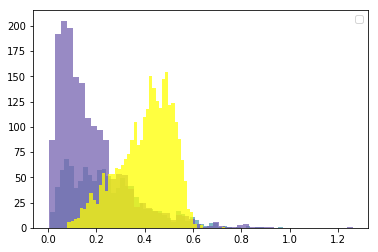

In [14]:
overlaid_histogram(p_z, m_z, r_z, n_bins = 50)

ValueError: supplied range of [1911.6636492777775, inf] is not finite

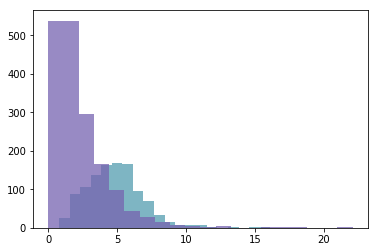

In [19]:
overlaid_histogram(p_m, m_m, r_m, n_bins = 20)

In [16]:
def ra_dec_distance(ra, dec, ra1, dec1):
    import numpy as np
    from astropy import units as u
    from astropy.coordinates import SkyCoord
    c1 = SkyCoord(ra=ra, dec=dec)
    c2 = SkyCoord(ra=ra1, dec=dec1)
    sep = c1.separation(c2)
    